In [497]:
import time
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import squarify
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import re

## Problem statement.

By analysing NYC-311 service request data and other demographic indicators like the poverty rate and racial diversity index, can we predict how long will it take for a request to be resolved?

## Data retrieval.

The main dataset I will be using is the ["311 Service Requests from 2010 to Present"](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data) dataset from NYC OpenData. This dataset contains all 311 Service Requests from 2010 to present, and it's updated daily. Given the size of the dataset, I decided to pull back the most recent 3 million requests to allow for easy manipulation of the data.

I used the [Socrata API](https://dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9) to pull back the data, see the API call in the following two cells. I excluded my personal account keys and username, but they are not necessary. If you want to recreate my steps and pull back the data, you can exclude the last three parameters used in the ```Socrata()``` function.

In [498]:
#from sodapy import Socrata
#start = time.time()
#client = Socrata("data.cityofnewyork.us",
#                  "---",
#                  username="---",
#                  password="---")
#client.timeout = 1200
#data = client.get("erm2-nwe9", limit=3000000)
#end = time.time()
#print(f"Time to retrieve rows: {round(end - start, 2)}")

In [499]:
#start = time.time()
#df = pd.DataFrame.from_records(data)
#end = time.time()
#print(f"Time to load data: {end - start}")

In [500]:
# exported the dataset into a parquet to avoid retrieving the data over and over.
#df.to_parquet('capstone_data.parquet.gzip', compression='gzip')

Additional datasets used are the [racial diversity index](https://app.coredata.nyc/?mlb=false&ntii=pop_race_div_idx&ntr=Sub-Borough%20Area&mz=14&vtl=https%3A%2F%2Fthefurmancenter.carto.com%2Fu%2Fnyufc%2Fapi%2Fv2%2Fviz%2F98d1f16e-95fd-4e52-a2b1-b7abaf634828%2Fviz.json&mln=true&mlp=false&mlat=40.729123&nty=2021&mb=roadmap&pf=%7B%22subsidies%22%3Atrue%7D&md=table&mlv=false&mlng=-73.992714&btl=Borough&atp=neighborhoods) and [poverty rate](https://app.coredata.nyc/?mlb=false&ntii=pop_pov_pct&ntr=Sub-Borough%20Area&mz=14&vtl=https%3A%2F%2Fthefurmancenter.carto.com%2Fu%2Fnyufc%2Fapi%2Fv2%2Fviz%2F98d1f16e-95fd-4e52-a2b1-b7abaf634828%2Fviz.json&mln=true&mlp=false&mlat=40.729123&nty=2021&mb=roadmap&pf=%7B%22subsidies%22%3Atrue%7D&md=table&mlv=false&mlng=-73.992714&btl=Borough&atp=neighborhoods) distributions from NYU's Furman Center, [median household income](https://simplemaps.com/city/new-york/zips/income-household-median) distribution by ZIP code from simplemaps, and the ["NYC Community Boards"](https://data.cityofnewyork.us/City-Government/NYC-Community-Boards/ruf7-3wgc/about_data) dataset from NYC OpenData. Columns from these datasets will be used to get a better picture of the location where the 311 requests where made from and extract valuable indicators related to the request's resolution time, if any.

## Data cleaning.

Cleaning the 311 Requests dataset first.

In [501]:
# import parquet file
req_df = pd.read_parquet("capstone_data.parquet.gzip")

Only keeping columns relevant to request type, location and resolution time. See the overview of all columns [here](https://github.com/heriberto00/Capstone/blob/main/data/311%20Requests%20Overview.md). 

In [502]:
req_df = req_df[['created_date', 'agency', 'agency_name', 'complaint_type', 'descriptor', 'incident_zip', 'borough', 'community_board',
                 'resolution_description', 'resolution_action_updated_date', 'closed_date', 'due_date']]

Excluding rows with invalid ZIP codes, since it'll later be used to join median income data.

In [503]:
req_df = req_df[req_df['incident_zip'].notna()]
req_df = req_df[req_df['incident_zip'] != "NA"]

In [504]:
# looking at total amount of duplicates
req_df.duplicated().sum()

27089

In [505]:
# not a significant amount, we can drop duplicates
req_df.drop_duplicates(inplace=True)

In [506]:
req_df.count()

created_date                      2936369
agency                            2936369
agency_name                       2936369
complaint_type                    2936369
descriptor                        2911360
incident_zip                      2936369
borough                           2936369
community_board                   2936369
resolution_description            2838677
resolution_action_updated_date    2869694
closed_date                       2768042
due_date                            15443
dtype: int64

In [507]:
# converting date columns from object to datetime for easier manipulation
req_df['created_date']= pd.to_datetime(req_df['created_date'])
req_df['resolution_action_updated_date']= pd.to_datetime(req_df['resolution_action_updated_date'])
req_df['closed_date']= pd.to_datetime(req_df['closed_date'])
req_df['due_date']= pd.to_datetime(req_df['due_date'])

In [508]:
# converting columns from object to string and int for easier manipulation
req_df['agency'] = req_df['agency'].astype("string")
req_df['agency_name'] = req_df['agency_name'].astype("string")
req_df['complaint_type'] = req_df['complaint_type'].astype("string")
req_df['descriptor'] = req_df['descriptor'].astype("string")
req_df['resolution_description'] = req_df['resolution_description'].astype("string")
req_df['borough'] = req_df['borough'].astype("string")
req_df['community_board'] = req_df['community_board'].astype("string")
req_df['incident_zip'] = req_df['incident_zip'].astype("string").astype("int")

In [509]:
# sorting and reseting index to have a chronological ordered dataset
req_df = req_df.sort_values(by=['created_date'])
req_df = req_df.reset_index(drop=True)

In [510]:
req_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936369 entries, 0 to 2936368
Data columns (total 12 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   created_date                    datetime64[ns]
 1   agency                          string        
 2   agency_name                     string        
 3   complaint_type                  string        
 4   descriptor                      string        
 5   incident_zip                    int64         
 6   borough                         string        
 7   community_board                 string        
 8   resolution_description          string        
 9   resolution_action_updated_date  datetime64[ns]
 10  closed_date                     datetime64[ns]
 11  due_date                        datetime64[ns]
dtypes: datetime64[ns](4), int64(1), string(7)
memory usage: 268.8 MB


In [511]:
req_df.shape

(2936369, 12)

After cleaning, the 311 Requests dataset has 2,936,369 rows with 12 columns.

---

Cleaning the median household income data. See the overview of all columns [here](https://github.com/heriberto00/Capstone/blob/main/data/Median%20Income%20Overview.md).

In [512]:
# importing median income data
income_df = pd.read_csv("median_income.csv")

In [513]:
income_df.duplicated().sum()

0

In [514]:
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   zip                 180 non-null    int64
 1   median_income_2022  180 non-null    int64
dtypes: int64(2)
memory usage: 2.9 KB


In [515]:
# no invalid or duplicated values, we only need to change column names to match 311 requests dataset
income_df = income_df.rename(columns={"zip":"incident_zip"})

After cleaning, median household income dataset has 180 rows with 2 columns.

---

Cleaning poverty rate data. See the overview of all columns [here](https://github.com/heriberto00/Capstone/blob/main/data/Poverty%20Rate%20Overview.md). 

In [516]:
# importing poverty rate data
poverty_df = pd.read_csv("poverty_rate.csv")

In [517]:
# only keep location and poverty rate related columns
poverty_df = poverty_df[["Sub-Borough Area", "2021"]]

In [518]:
poverty_df.duplicated().sum()

0

In [519]:
poverty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sub-Borough Area  55 non-null     object 
 1   2021              55 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1012.0+ bytes


In [520]:
poverty_df['Sub-Borough Area'] = poverty_df['Sub-Borough Area'].astype("string")

In [521]:
# no invalid or duplicated values, we only need to change column names for easier manipulation
poverty_df = poverty_df.rename(columns={"Sub-Borough Area":"sub_borough_area", "2021":"poverty_rate_2021"})

After cleaning, poverty rate dataset has 55 rows with 2 columns.

---

Cleaning racial diversity index data. See the overview of all columns [here](https://github.com/heriberto00/Capstone/blob/main/data/Racial%20Diversity%20Index%20Overview.md).

In [522]:
# importing racial diversity index data
diversity_df = pd.read_csv("racial_diversity_index.csv")

In [523]:
# only keep location and diversity index related columns
diversity_df = diversity_df[["Sub-Borough Area", "2021"]]

In [524]:
diversity_df.duplicated().sum()

0

In [525]:
diversity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sub-Borough Area  55 non-null     object 
 1   2021              55 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1012.0+ bytes


In [526]:
# no invalid or duplicated values, we only need to change column names for easier manipulation
diversity_df = diversity_df.rename(columns={"Sub-Borough Area":"sub_borough_area", "2021":"diversity_index_2021"})

After cleaning, diversity index dataset has 55 rows with 2 columns.

---

## Data preprocessing and preliminary EDA.

First, I'll join the main 311 Requests dataset with the relevant columns extracted from the racial diversity index data, poverty rate data, and median household income data.

In [527]:
# we can easily join these 2 datasets, using the many-to-one validation parameter to double-check we only get one value per ZIP code
req_df = req_df.merge(income_df, on="incident_zip", how="left", validate="m:1")

The closest location attribute that can be used from the 311 Requests dataset to join with  the racial diversity index and poverty rate datasets is the ```community_board``` column. These can be joined to each corresponding ```sub_borough_area```, given community board divisions closely resemble sub-borough divisions.

Community boards in NYC are advisory boards made up of community members. They make important recommendations about land use, zoning, and other local issues. These are comprised of multiple neighborhoods, and by using NYC OpenData's ["NYC Community Boards"](https://data.cityofnewyork.us/City-Government/NYC-Community-Boards/ruf7-3wgc/about_data) dataset and this [NYC Sub-Borough map](https://github.com/heriberto00/Capstone/blob/main/data/datasets/subboro.pdf), I was able to find and assign the corresponding ```community_board``` to each ```sub_borough_area``` in the racial diversity index and poverty rate datasets using the ```neighborhoods``` value in the community boards dataset. You can see the overview of columns in the "NYC Community Boards" dataset [here](https://github.com/heriberto00/Capstone/blob/main/data/NYC%20Community%20Boards%20Overview.md).

I manually went through the community boards dataset and assigned each sub-borough the closest corresponding value. I understand this is not ideal, and I'm planning on automating this step in the final version of data preprocessing.

In [528]:
# manually assigning each community_board depening on sub_borough_area
poverty_df.loc[poverty_df['sub_borough_area'] == 'Greenwich Village/Financial District', ['community_board']] = '02 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Lower East Side/Chinatown', ['community_board']] = '03 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Kingsbridge Heights/Mosholu', ['community_board']] = '07 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Riverdale/Kingsbridge', ['community_board']] = '08 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Soundview/Parkchester', ['community_board']] = '09 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Throgs Neck/Co-op City', ['community_board']] = '10 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Pelham Parkway', ['community_board']] = '11 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Williamsbridge/Baychester', ['community_board']] = '12 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Williamsburg/Greenpoint', ['community_board']] = '01 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Brooklyn Heights/Fort Greene', ['community_board']] = '02 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Bedford Stuyvesant', ['community_board']] = '03 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Bushwick', ['community_board']] = '04 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'East New York/Starrett City', ['community_board']] = '05 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Park Slope/Carroll Gardens', ['community_board']] = '06 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Sunset Park', ['community_board']] = '07 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'North Crown Heights/Prospect Heights', ['community_board']] = '08 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Elmhurst/Corona', ['community_board']] = '04 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Middle Village/Ridgewood', ['community_board']] = '05 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Rego Park/Forest Hills', ['community_board']] = '06 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Flushing/Whitestone', ['community_board']] = '07 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Hillcrest/Fresh Meadows', ['community_board']] = '08 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Ozone Park/Woodhaven', ['community_board']] = '09 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'South Ozone Park/Howard Beach', ['community_board']] = '10 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Bayside/Little Neck', ['community_board']] = '11 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Jamaica', ['community_board']] = '12 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Queens Village', ['community_board']] = '13 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Rockaways', ['community_board']] = '14 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'North Shore', ['community_board']] = '01 STATEN ISLAND'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Mid-Island', ['community_board']] = '02 STATEN ISLAND'
poverty_df.loc[poverty_df['sub_borough_area'] == 'South Shore', ['community_board']] = '03 STATEN ISLAND'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Chelsea/Clinton/Midtown', ['community_board']] = '04 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Stuyvesant Town/Turtle Bay', ['community_board']] = '06 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Upper West Side', ['community_board']] = '07 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Upper East Side', ['community_board']] = '08 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Morningside Heights/Hamilton Heights', ['community_board']] = '09 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Central Harlem', ['community_board']] = '10 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'East Harlem', ['community_board']] = '11 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Washington Heights/Inwood', ['community_board']] = '12 MANHATTAN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Mott Haven/Hunts Point', ['community_board']] = '01 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Morrisania/Belmont', ['community_board']] = '02 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Highbridge/South Concourse', ['community_board']] = '04 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'University Heights/Fordham', ['community_board']] = '05 BRONX'
poverty_df.loc[poverty_df['sub_borough_area'] == 'South Crown Heights', ['community_board']] = '09 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Bay Ridge', ['community_board']] = '10 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Bensonhurst', ['community_board']] = '11 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Borough Park', ['community_board']] = '12 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Coney Island', ['community_board']] = '13 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Flatbush', ['community_board']] = '14 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Sheepshead Bay/Gravesend', ['community_board']] = '15 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Brownsville/Ocean Hill', ['community_board']] = '16 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'East Flatbush', ['community_board']] = '17 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Flatlands/Canarsie', ['community_board']] = '18 BROOKLYN'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Astoria', ['community_board']] = '01 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Sunnyside/Woodside', ['community_board']] = '02 QUEENS'
poverty_df.loc[poverty_df['sub_borough_area'] == 'Jackson Heights', ['community_board']] = '03 QUEENS'

/var/folders/pr/nn4kwc9x6qs3_2gfmhsfv1vr0000gn/T/ipykernel_79264/3850970075.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '02 MANHATTAN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  poverty_df.loc[poverty_df['sub_borough_area'] == 'Greenwich Village/Financial District', ['community_board']] = '02 MANHATTAN'


In [529]:
# merge diversity_df with poverty_df to get already assigned community_board values
diversity_df = diversity_df.merge(poverty_df[['sub_borough_area','community_board']], on="sub_borough_area", how="left", validate="m:1")

In [530]:
# manually adding index for 05 MANHATTAN community board because of overlapping neighborhoods
diversity_df = diversity_df[['diversity_index_2021', 'community_board']]
man05 = pd.DataFrame({'diversity_index_2021':[0.584941], 'community_board': ['05 MANHATTAN']})
diversity_df = diversity_df._append(man05, ignore_index = True)

In [531]:
# manually adding rate for 05 MANHATTAN community board because of overlapping neighborhoods
poverty_df = poverty_df[['poverty_rate_2021', 'community_board']]
man05 = pd.DataFrame({'poverty_rate_2021':[0.111038], 'community_board': ['05 MANHATTAN']})
poverty_df = poverty_df._append(man05, ignore_index = True)

In [532]:
# merge dataframes with main dataframe containing 311 requests
req_df = req_df.merge(poverty_df[['poverty_rate_2021','community_board']], on="community_board", how="left", validate="m:1")
req_df = req_df.merge(diversity_df[['diversity_index_2021','community_board']], on="community_board", how="left", validate="m:1")

In [533]:
req_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936369 entries, 0 to 2936368
Data columns (total 15 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   created_date                    datetime64[ns]
 1   agency                          string        
 2   agency_name                     string        
 3   complaint_type                  string        
 4   descriptor                      string        
 5   incident_zip                    int64         
 6   borough                         string        
 7   community_board                 object        
 8   resolution_description          string        
 9   resolution_action_updated_date  datetime64[ns]
 10  closed_date                     datetime64[ns]
 11  due_date                        datetime64[ns]
 12  median_income_2022              float64       
 13  poverty_rate_2021               float64       
 14  diversity_index_2021            float64       
dty

In [534]:
req_df.shape

(2936369, 15)

Merged dataframes contain 2,936,369 rows and 15 columns.

---

See premilimary EDA below.

In [535]:
req_df.head(1)

,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,borough,community_board,resolution_description,resolution_action_updated_date,closed_date,due_date,median_income_2022,poverty_rate_2021,diversity_index_2021
0,2023-06-10 21:11:28,NYPD,New York City Police Department,Non-Emergency Police Matter,Other (complaint details),10465,BRONX,10 BRONX,The Police Department responded to the complai...,2023-06-10 21:27:28,2023-06-10 21:27:23,NaT,80245.0,0.139823,0.690039


Earliest request is from 2023-06-10.

In [415]:
req_df.tail(1)

,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,borough,community_board,resolution_description,resolution_action_updated_date,closed_date,due_date,median_income_2022,poverty_rate_2021,diversity_index_2021
2936368,2024-05-06 00:57:00,DOT,Department of Transportation,Traffic Signal Condition,Controller,10024,MANHATTAN,07 MANHATTAN,<NA>,NaT,NaT,NaT,153177.0,0.103805,0.560142


Latest request is from 2024-05-06.

In [564]:
req_df['complaint_type'].unique()

<StringArray>
['Non-Emergency Police Matter',         'Noise - Residential',
             'Noise - Vehicle',     'Noise - Street/Sidewalk',
       'Real Time Enforcement',                'Noise - Park',
          'Noise - Commercial',            'Blocked Driveway',
             'Illegal Parking',               'Lot Condition',
 ...
  'DOB Posted Notice or Order',   'Public Payphone Complaint',
        'Non-Residential Heat',              'Unlicensed Dog',
    'Building Marshals office',         'Seasonal Collection',
                         'SNW',   "Building Marshal's Office",
       'Executive Inspections',  'Sustainability Enforcement']
Length: 201, dtype: string

We have 201 unique complaint types, ideally I'll be able to reconcile them. With a quick glance we can see that there are multiple types of noise complaints that can be easily reconciled. Further cleaning and analysis will be done to better represent complaint types in the final version of EDA.

In [574]:
np.max(req_df['closed_date'] - req_df['created_date'])

Timedelta('324 days 10:24:33')

Roughly, the max resolution time of a service request was 324 days and 10 hours.

In [575]:
np.mean(req_df['closed_date'] - req_df['created_date'])

Timedelta('6 days 20:45:16.109208602')

Roughly, it takes 6 days and 20 hours on average for a service request to be closed.

This tells us there's potential outliers in the distribution of resolution times for service requests. Further analysis on this distribution will be done on for the final version of EDA.

In [416]:
# group by borough to get total requests made, ignore "uncategorized" since it's not a significant amount of requests
borough_totals = req_df.groupby(by="borough").count()
borough_totals = borough_totals.loc[borough_totals['created_date'] > 400]

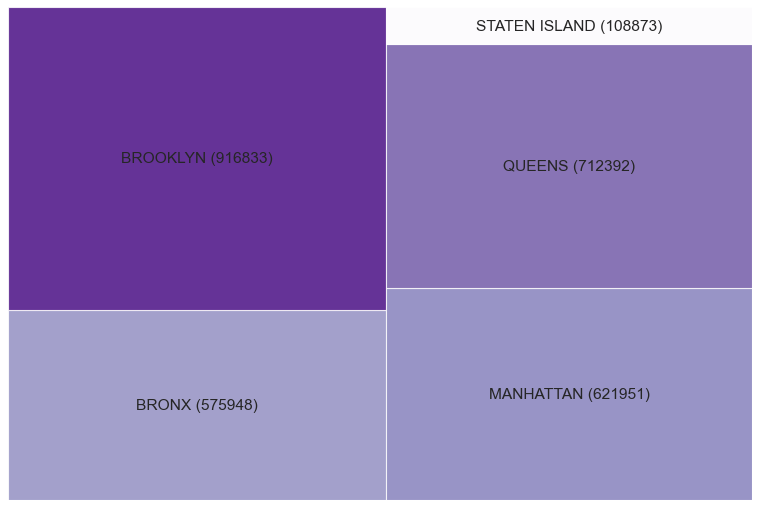

<Figure size 640x480 with 0 Axes>

In [418]:
# use squarefy to produce treemap of amount of requests per borough
cmap = matplotlib.cm.Purples
mini = min(borough_totals['created_date'])
maxi = max(borough_totals['created_date'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(total)) for total in borough_totals['created_date']]
labels = [f'{borough} ({str(total)})' for borough, total in zip(borough_totals.index.values, borough_totals['created_date'])]

plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=borough_totals['created_date'], label=labels, alpha=.8, color=colors, text_kwargs={'fontsize':14})
plt.axis('off')
plt.show()
plt.savefig('requests_per_borough.png')

We can see most requests are made from Brooklyn, with 916,833 total requests. Queens comes in second, then Manhattan, the Bronx, and Staten Island in last place. Population sizes and distribution are aspects worth exploring to see how representative these values are.

I'd like to get some insight on the amount of requests made per month, to see if there are any interesting trends. This analysis should not be considered complete or representative, since we're not retrieving data for a complete year. In the final version of EDA, I'll look into retrieving rows from all months of the year to get a more significant picture.

In [419]:
# group by month and year to get totals
monthly_totals = req_df.groupby(by=[req_df.created_date.dt.month, req_df.created_date.dt.year]).count()
monthly_totals.index.rename(['month', 'year'], inplace=True)
monthly_totals = monthly_totals[['created_date']]

In [420]:
# separate by year since I don't currently have consistent monthly data for both years
monthly_totals_2023 = monthly_totals[monthly_totals.index.get_level_values("year").isin([2023])]
monthly_totals_2023.reset_index(inplace=True)
monthly_totals_2024 = monthly_totals[monthly_totals.index.get_level_values("year").isin([2024])]
monthly_totals_2024.reset_index(inplace=True)

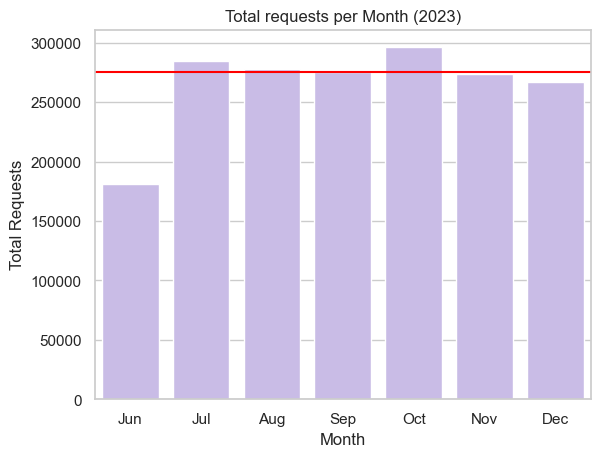

<Figure size 640x480 with 0 Axes>

In [422]:
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x='month', y='created_date', data=monthly_totals_2023, color='#C6B5ED')
plt.title('Total requests per Month (2023)')
plt.xticks(np.arange(0,7),['Jun','Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.axhline(y=np.nanmedian(monthly_totals_2023['created_date']), color='red')
plt.xlabel('Month')
plt.ylabel('Total Requests')
plt.show()
plt.savefig('2023_requests_per_month.png')

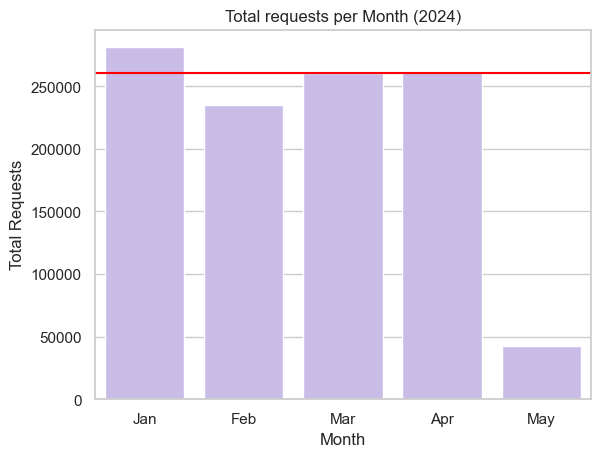

<Figure size 640x480 with 0 Axes>

In [423]:
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x='month', y='created_date', data=monthly_totals_2024, color='#C6B5ED')
plt.title('Total requests per Month (2024)')
plt.xticks(np.arange(0,5),['Jan','Feb','Mar', 'Apr', 'May'])
plt.axhline(y=np.nanmedian(monthly_totals_2024['created_date']), color='red')
plt.xlabel('Month')
plt.ylabel('Total Requests')
plt.show()
plt.savefig('2024_requests_per_month.png')

I'm interested in the share of requests that have a registered resolution date, this should show the amount of data I'll be able to use in a model to predict the resolution time of a service request.

In [432]:
closed_req = req_df[req_df['closed_date'].notnull()]
not_closed_req = req_df[req_df['closed_date'].isnull()]

In [433]:
closed_req.shape

(2768042, 15)

In [434]:
not_closed_req.shape

(168327, 15)

2,768,042 requests have a closed date, and 168,327 don't. This tells us the majority get a closed date, further analysis using ```resolution_description``` can tell us more about what actions are being registered as resolutions.

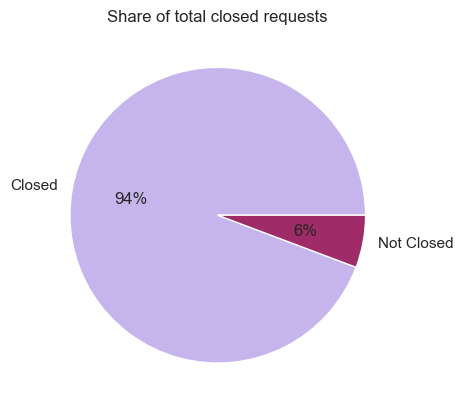

<Figure size 640x480 with 0 Axes>

In [441]:
plt.pie([2768042, 168327], labels=['Closed', 'Not Closed'], colors= ['#C6B5ED', '#9F2B68'], autopct='%.0f%%')
plt.title('Share of total closed requests')
plt.show()
plt.savefig('requests_closed.png')

Another interesting insight is the distribution of the demographic indicators we have so far. Thanks to the initial merge of datasets, we can now get an aggregate by borough.

In [553]:
# group by borough to mean poverty rate and racial diversity index
borough_poverty_diversity = req_df[['borough','poverty_rate_2021','diversity_index_2021']].groupby(by="borough").mean()
borough_poverty_diversity.dropna(inplace=True)
borough_poverty_diversity.reset_index(inplace=True)

In [554]:
# transform dataframe for easier use in grouped bar chart
borough_poverty_diversity.set_index('borough', inplace=True)
borough_poverty_diversity = borough_poverty_diversity.stack().to_frame('value').reset_index()
borough_poverty_diversity.rename(columns={'level_1':'measure'},inplace=True)

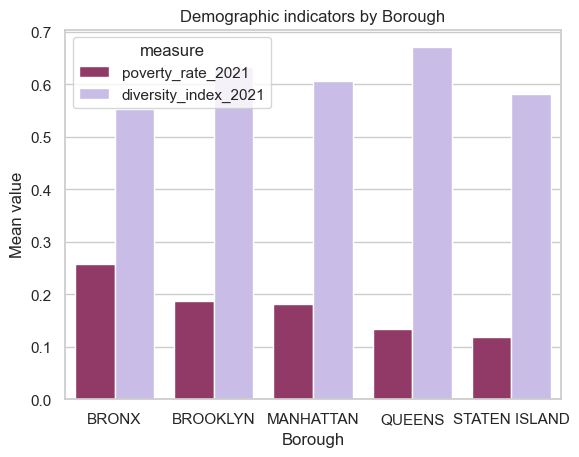

<Figure size 640x480 with 0 Axes>

In [563]:
sns.set(style="whitegrid", color_codes=True)
sns.barplot(data=borough_poverty_diversity, x='borough', y='value', hue='measure', palette= ['#9F2B68', '#C6B5ED'])
plt.title('Demographic indicators by Borough')
plt.xlabel('Borough')
plt.ylabel('Mean value')
plt.show()
plt.savefig('demographics_borough.png')

There is some variation across boroughs for the 2 demographic indicators I've included. The Bronx has the highest mean poverty rate, with the lowest racial diversity index. Queens has the highest mean racial diversity rate, and Staten Island has the lowest poverty rate of all boroughs.

---

## Concerns.

One of my main concerns is not using chronologically consistent data for this project. Given the size of the main 311 requests dataset, I'm not able to select a specific amount of rows per available year. I'd like to expand the size of the main dataset to run the analysis and modeling with a more consistent timeframe for the 311 requests. 

Another concern is missing features, not having enough demographic indicators to extract significant insights from the main dataset would make the final model less useful.

## Next steps.

In addition to the already mentioned steps that will be done for the final version of processing and EDA, I'd like to do a more granular analysis of the requests types, getting their distributions per borough or even community board. It would be interesting to determine what type of complaint one is most likely to encounter depending on a specific location. 

For future feature engineering, I'd like to explore the addition of binary variables for the demographic variables to determine low/high income variability, low/high diversity and low/high poverty rates. Geographical dummy variables for borough or community board could also be beneficial for easier modeling. Dummy variables for service request attributes such as responsible city agency and month of year could also be beneficial. 

For baseline modeling, I believe a linear regression would be a good first step to find the appropriate prediction model for service request resolution times. This has not been covered yet, but survival analysis might  also be a good approach to predicting resolution times.